In [322]:
import sys
sys.path.append('/home/chris/repos/financial_analysis/')
import pandas as pd

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [323]:
from credentials import *

### Testing the Alpha Vantage API by pulling DAX data

In [324]:
import requests
import json
import pprint

url = "https://www.alphavantage.co/query"
outFile = '../newfile.csv'
function = "TIME_SERIES_DAILY"
symbol = "^STOXX50E"
api_key = key

data = { "function": function, 
         "symbol": symbol, 
         "apikey": api_key,
         "outputsize": 'compact',
         "datatype": 'csv'} 
page = requests.get(url, params = data)
#pprint.pprint(page.json())

with open(outFile, 'w') as oF:
    oF.write(page.text)

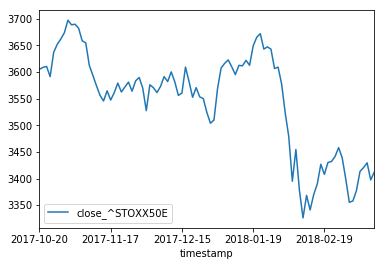

In [325]:
df = pd.read_csv('../newfile.csv',usecols=["timestamp", "close"]).rename(columns={'close' : 'close_'+symbol})
df.loc[(df==0).any(axis=1)].index
df = df.drop(df.loc[(df==0).any(axis=1)].index)
df = df.iloc[::-1]
df.plot(x='timestamp',y='close_'+symbol)

In [326]:
from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt

ts = TimeSeries(key=api_key, output_format='pandas')
data, meta_data = ts.get_daily(symbol=symbol, outputsize='compact')


In [327]:
test = data.drop(data.columns[4], axis=1)
test = test.drop(test.loc[(test==0).any(axis=1)].index)  

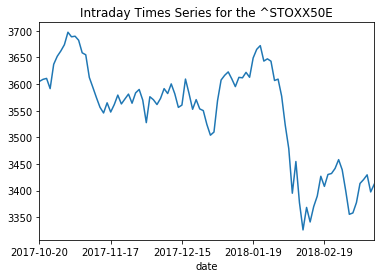

In [328]:
test['4. close'].plot()
plt.title('Intraday Times Series for the '+ symbol)
plt.show()

### Now pull a bunch of relevant indices

* Plot time series
* Plot their correlations

In [329]:
indices = [
    '^GDAXI',#DAX
    '^GSPC', #S&P 500
    '^DJI',  #DowJones 30
    #'^IXIC', #NASDAQ
    '^NYA', #NYSE COMPOSITE (DJ)
    '^XAX',  #NYSE AMEX COMPOSITE INDEX
    #'^BATSK',#BATS 1000 Index
    '^RUT',  #Russell 2000
    '^FTSE', #FTSE 100
    '^FCHI', #CAC 40
    '^STOXX50E', #STOXX 50
    '^N100', #EURONEXT 100
    '^BFX',  #BEL 20 Brussels
    '^N225', #Nikkei
    '^HSI',  #Hangseng   
    'EOAN.DE'
]


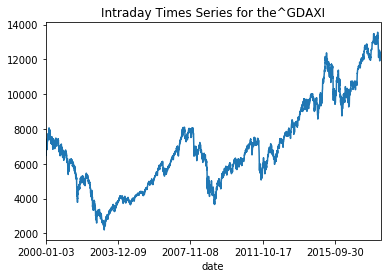

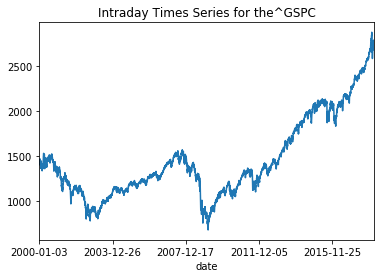

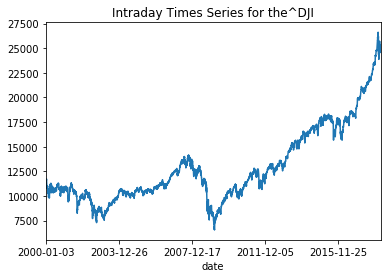

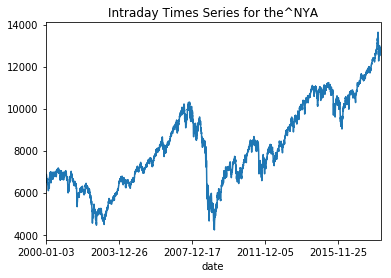

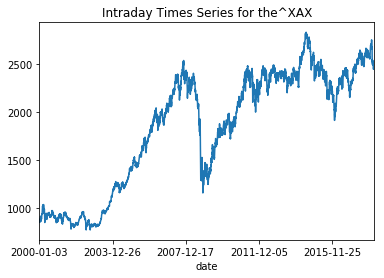

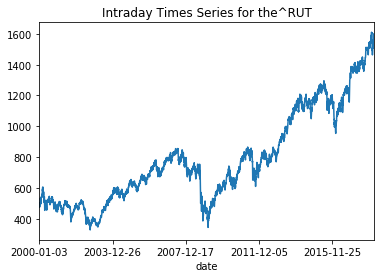

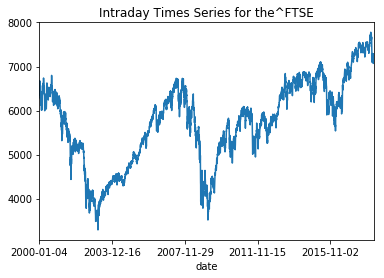

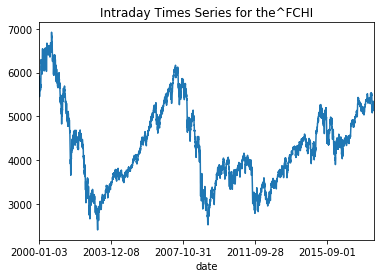

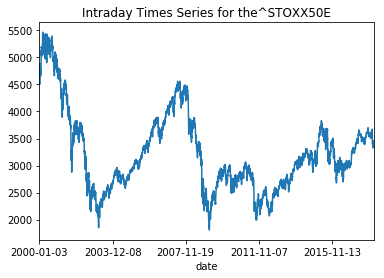

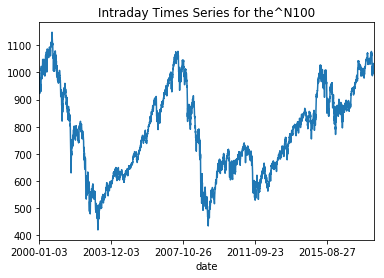

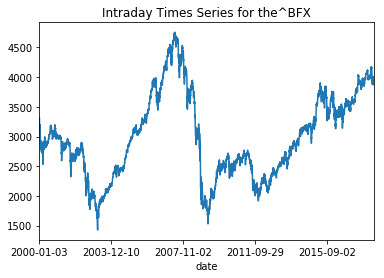

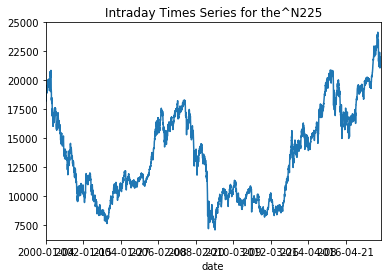

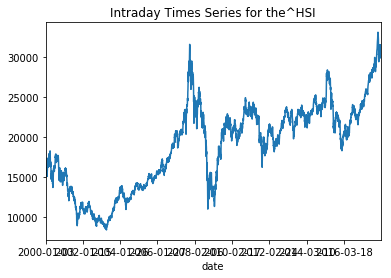

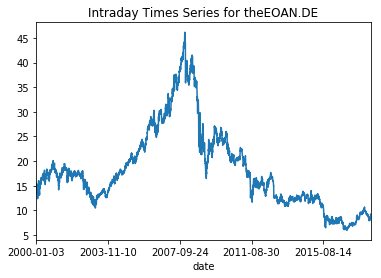

In [330]:
from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt

for asset in indices:
    ts = TimeSeries(key=api_key, output_format='pandas')
    data, meta_data = ts.get_daily(symbol=asset, outputsize='full')
    data = data.drop(data.columns[4], axis=1)
    data = data.drop(data.loc[(data==0).any(axis=1)].index)    
    data['4. close'].plot()
    plt.title('Intraday Times Series for the' + asset )
    plt.show()

In [331]:
url = "https://www.alphavantage.co/query"
index_data_dir = '../data/'
function = "TIME_SERIES_DAILY"
symbol = "^GDAXI"
api_key = key

for index in indices:
    data = { "function": function, 
         "symbol": index, 
         "apikey": api_key,
         "outputsize": 'compact',
         "datatype": 'csv'} 
    page = requests.get(url, params = data)
    with open(index_data_dir + 'data_' + index.strip('^') + '.csv', 'w') as oF:
        oF.write(page.text)

In [332]:
import glob

allFiles = glob.glob(index_data_dir + "*.csv")
df_indices = pd.DataFrame()
list_ = []
for file_ in allFiles:
    name = str(str(file_).split('_')[1]).split('.')[0]
    print(name)
    #Drop redundant timestamps
    df = pd.read_csv(file_,usecols=["timestamp", "close"]).rename(columns={'timestamp' : 'timestamp_'+name, 'close' : 'close_'+name})
    #df = df.drop(df.loc[(df==0).any(axis=1)].index)    
    list_.append(df)
df_indices = pd.concat(list_, axis=1)
df_indices = df_indices.iloc[::-1]
df_indices = df_indices.drop(df_indices.loc[(df_indices==0).any(axis=1)].index)  

RUT
GSPC
BFX
N225
HSI
DJI
STOXX50E
GDAXI
NYA
EOAN
FTSE
XAX
FCHI
N100


In [333]:
df_indices.shape

(88, 28)

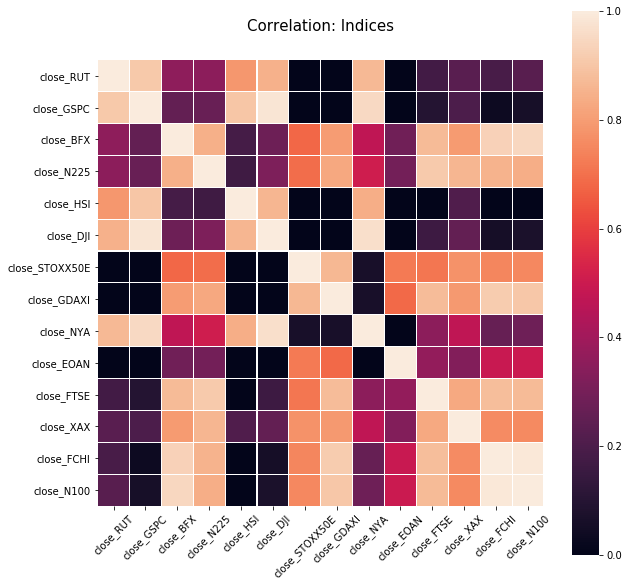

In [334]:
import seaborn as sns
import matplotlib.pyplot as plt

df_indices = df_indices.filter(regex='close', axis=1)


plt.figure(figsize=(10,10))
plt.title('Correlation: Indices', y=1.05, size=15)
plot = sns.heatmap(df_indices.corr(), xticklabels=df_indices.columns, yticklabels=df_indices.columns,  linewidths=0.1,vmax=1.0,vmin=0, square=True, linecolor='white')
#plot.set_xticklabels(plot.get_xticklabels(),rotation=30)
#plot.set_ylabel('')
#plot.set_xlabel('')
plt.setp(plot.get_xticklabels(), rotation=45)
plt.setp(plot.get_yticklabels(), rotation=0)

plt.show()



### First simple predictive model

In [335]:
import matplotlib.pyplot as plt
import numpy as np
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM,Dense

In [336]:
np.random.seed(7)

In [337]:
df_indices = df_indices.fillna(0)

In [338]:
#df_indices = df_indices.drop(df_indices.loc[(df_indices==0).any(axis=1)].index)
#df_indices = scaler.fit_transform(df_indices.filter(regex='close'))

In [339]:
#Define asset to be predicted
predicted_asset = 'close_EOAN'
asset_position = list(df_indices.columns).index(predicted_asset)
print(asset_position)

9


In [340]:
#df_indices.close_GDAXI

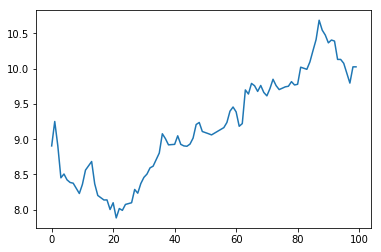

In [341]:
plt.plot(df_indices[predicted_asset])

In [342]:
cols = list(df_indices)
cols.insert(0, cols.pop(cols.index(predicted_asset)))
df_indices = df_indices.loc[:, cols]

In [343]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [344]:
 # load dataset
dataset = df_indices
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.iloc[:, df_indices.shape[1]+1:reframed.shape[1]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.764286   0.188096   0.026419   0.716673   0.252874   0.000000   
2   0.764286   0.209107   0.040421   0.724668   0.402299   0.030741   
3   0.682143   0.159340   0.000000   0.680859   0.459770   0.009853   
4   0.782143   0.265758   0.080708   0.803771   0.471264   0.037661   
5   0.801786   0.140839   0.052905   0.757491   0.758621   0.018822   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1   0.000000   0.751461   0.779203    0.083814    0.587837    0.485565   
2   0.053009   0.761639   0.833038    0.100342    0.613941    0.456533   
3   0.017533   0.766539   0.840724    0.045374    0.589671    0.388909   
4   0.050617   0.837914   0.991470    0.069358    0.589953    0.527092   
5   0.023623   0.878383   0.975766    0.031626    0.684916    0.552113   

   var13(t-1)  var14(t-1)   var1(t)  
1    0.812891    0.784943  0.764286  
2    0.896581    0.855662  0.682143  
3    0.895500 

In [345]:
reframed.shape,df_indices.shape

((87, 15), (88, 14))

In [346]:
reframed.shape, df_indices.shape, values.shape

((87, 15), (88, 14), (88, 14))

In [347]:
# split into train and test sets
values = reframed.values
train = values[:40, :]
test = values[40:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [348]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(40, 1, 14) (40,) (47, 1, 14) (47,)


Train on 40 samples, validate on 47 samples
Epoch 1/200
 - 3s - loss: 0.7446 - val_loss: 0.2427
Epoch 2/200
 - 0s - loss: 0.6972 - val_loss: 0.1925
Epoch 3/200
 - 0s - loss: 0.6498 - val_loss: 0.1440
Epoch 4/200
 - 0s - loss: 0.6023 - val_loss: 0.1063
Epoch 5/200
 - 0s - loss: 0.5575 - val_loss: 0.0854
Epoch 6/200
 - 0s - loss: 0.5095 - val_loss: 0.0793
Epoch 7/200
 - 0s - loss: 0.4624 - val_loss: 0.1042
Epoch 8/200
 - 0s - loss: 0.4134 - val_loss: 0.1411
Epoch 9/200
 - 0s - loss: 0.3635 - val_loss: 0.1869
Epoch 10/200
 - 0s - loss: 0.3129 - val_loss: 0.2380
Epoch 11/200
 - 0s - loss: 0.2631 - val_loss: 0.2930
Epoch 12/200
 - 0s - loss: 0.2202 - val_loss: 0.3487
Epoch 13/200
 - 0s - loss: 0.1841 - val_loss: 0.4049
Epoch 14/200
 - 0s - loss: 0.1494 - val_loss: 0.4629
Epoch 15/200
 - 0s - loss: 0.1230 - val_loss: 0.5179
Epoch 16/200
 - 0s - loss: 0.1151 - val_loss: 0.5667
Epoch 17/200
 - 0s - loss: 0.1221 - val_loss: 0.6061
Epoch 18/200
 - 0s - loss: 0.1358 - val_loss: 0.6342
Epoch 19/20

Epoch 154/200
 - 0s - loss: 0.0374 - val_loss: 0.1703
Epoch 155/200
 - 0s - loss: 0.0372 - val_loss: 0.1683
Epoch 156/200
 - 0s - loss: 0.0371 - val_loss: 0.1677
Epoch 157/200
 - 0s - loss: 0.0370 - val_loss: 0.1690
Epoch 158/200
 - 0s - loss: 0.0368 - val_loss: 0.1704
Epoch 159/200
 - 0s - loss: 0.0367 - val_loss: 0.1708
Epoch 160/200
 - 0s - loss: 0.0366 - val_loss: 0.1694
Epoch 161/200
 - 0s - loss: 0.0364 - val_loss: 0.1674
Epoch 162/200
 - 0s - loss: 0.0363 - val_loss: 0.1664
Epoch 163/200
 - 0s - loss: 0.0363 - val_loss: 0.1674
Epoch 164/200
 - 0s - loss: 0.0360 - val_loss: 0.1702
Epoch 165/200
 - 0s - loss: 0.0360 - val_loss: 0.1709
Epoch 166/200
 - 0s - loss: 0.0360 - val_loss: 0.1699
Epoch 167/200
 - 0s - loss: 0.0358 - val_loss: 0.1671
Epoch 168/200
 - 0s - loss: 0.0356 - val_loss: 0.1654
Epoch 169/200
 - 0s - loss: 0.0357 - val_loss: 0.1676
Epoch 170/200
 - 0s - loss: 0.0354 - val_loss: 0.1686
Epoch 171/200
 - 0s - loss: 0.0355 - val_loss: 0.1677
Epoch 172/200
 - 0s - loss: 

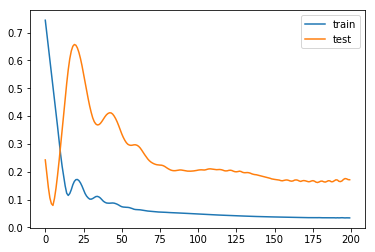

In [349]:
# design network
model = Sequential()
model.add(LSTM(300, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
#model.add(Dense(1, activation='tanh'))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=40, validation_data=(test_X, test_y), verbose=2, shuffle=True)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [350]:
yhat = model.predict(test_X)
#test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X.reshape((test_X.shape[0], test_X.shape[2]))[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)

In [351]:
#test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
test_X.shape

(47, 1, 14)

In [352]:
yhat = model.predict(test_X)

In [353]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.529


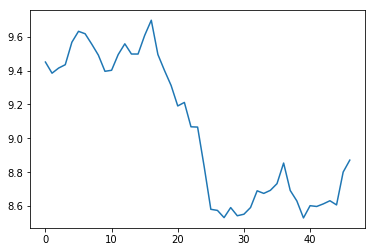

In [354]:
plt.plot(inv_yhat)

In [355]:
historic = np.array(df_indices[predicted_asset])
future = inv_yhat
prediction = np.append(historic,future)  

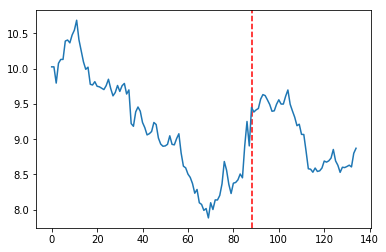

In [356]:
plt.axvline(x=len(historic), linestyle='--', color='red')
plt.plot(prediction)

In [357]:
future[0],historic.mean()

(9.450517, 9.197295454545454)

In [358]:
future.min(), future.max()

(8.530563, 9.697184)

In [359]:
number_of_steps = 20
def predictive_model(test_X,train_y):
    for neuron_number in np.linspace(50,1000,number_of_steps):
        # design network
        model = Sequential()
        model.add(LSTM(neuron_number, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(1))
        #model.add(Dense(1, activation='tanh'))
        model.compile(loss='mae', optimizer='adam')
        # fit network
        history = model.fit(train_X, train_y, epochs=200, batch_size=40, validation_data=(test_X, test_y), verbose=2, shuffle=True)
        # plot history
        pyplot.plot(history.history['loss'], label='train')
        pyplot.plot(history.history['val_loss'], label='test')
        pyplot.legend()
        pyplot.show()
        yhat = model.predict(test_X)

In [360]:
for i in range(number_of_steps):
    predictive_model(test_X,train_y)
    

TypeError: Value passed to parameter 'shape' has DataType float32 not in list of allowed values: int32, int64